In [43]:
embedding_dict = {} # 각 사진들의 임베딩 저장
cropped_face_dict = {} # 얼굴 이미지 저장
import face_recognition
import matplotlib.pyplot as plt
import matplotlib.image as img
import os 
# images 디렉토리 안에 있는 모든 이미지 파일의 임베디을 구해서 dict 구조에 담아 리턴하는 함수
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)

    for file in file_list:
        img_path = os.path.join(dir_path, file)

        image = face_recognition.load_image_file(img_path)
        face_locations = face_recognition.face_locations(image)
        # face_locations = face_recognition.face_locations(image, number_of_times_to_upsample=0, model="cnn")

        if not face_locations: # 얼굴 위치를 찾지 못하는 경우
            print(f"Cannot crop the image: {file}")
            continue

        else: # 얼굴 부분만 잘라낸다
            a, b, c, d = face_locations[0]
            cropped_face = image[a:c, d:b, :]

        embedding = face_recognition.face_encodings(cropped_face)

        if not embedding: # 임베딩 벡터를 구하지 못하는 경우
            print(f"Cannot get embedding of the image: {file}")
            continue

        if len(embedding) > 0:
            # 얼굴영역 face가 제대로 detect 되지 않으면 len(embedding) == 0인 경우가 발생하므로
            # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담긴다
            embedding_dict[os.path.splitext(file)[0]] = embedding[0]
            cropped_face_dict[os.path.splitext(file)[0]] = cropped_face

    return embedding_dict

디렉토리 path를 받아서 해당 디렉토리 안에 있는 모든 파일을 읽어들인다. 모든 파일을 읽어들이면서 얼굴을 자르고 임베딩 벡터를 구해서 딕셔너리에 {파일명: 임베딩벡터}의 형태로 저장하고 반환한다. 

In [44]:
dir_path =os.getenv('HOME')+'/aiffel/face_embedding/image/celebrity' 

embedding_dict=get_face_embedding_dict(dir_path)



Cannot get embedding of the image: 제프리 힌턴.jpg
Cannot get embedding of the image: 매드클라운.jpeg


In [45]:
import numpy as np

# 두 임베딩 벡터 간의 거리를 계산하는 함수
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1] - embedding_dict[name2], ord=2)

# name1과 name2의 거리를 비교하는 함수를 생성
# name1은 미리 지정하고, name2는 호출시에 인자로 받도록 한다
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

# sort_key_func = get_sort_key_func('trump')
# 이렇게 생성된 함수 sort_key_func는 sort_key_func('obama') 라고 호출할 때 trump와 obama 사이의 임베딩 벡터 거리를 계산합니다.



def find_celebrity_resemblance(name, top=5):
    # name = input()
    def get_nearest_face(name, top=5):
        sort_key_func = get_sort_key_func(name)
        sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
        
        for i in range(top+1):
            if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다. 
                continue
            if sorted_faces[i]:
                print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
        
        return sorted_faces


    print()
    sorted_faces = get_nearest_face(name, top)
    fig = plt.figure(figsize=(12, 10))

    fig.add_subplot(1, top, 1)
    plt.imshow(cropped_face_dict[sorted_faces[0][0]])
    
    for i in range(1, 6):
        fig.add_subplot(2, top, i + top)
        plt.imshow(cropped_face_dict[sorted_faces[i][0]])

In [ ]:
임베딩 벡터의 거리를 기준으로 자신을 제외한 가장 가까운 5명을 뽑는다. 


순위 1 : 이름(배성재), 거리(0.2327666075031332)
순위 2 : 이름(최양락), 거리(0.3609339782501518)
순위 3 : 이름(박휘순), 거리(0.37943214553010557)
순위 4 : 이름(안재홍), 거리(0.38377568923765676)
순위 5 : 이름(박건우), 거리(0.3973927739014846)


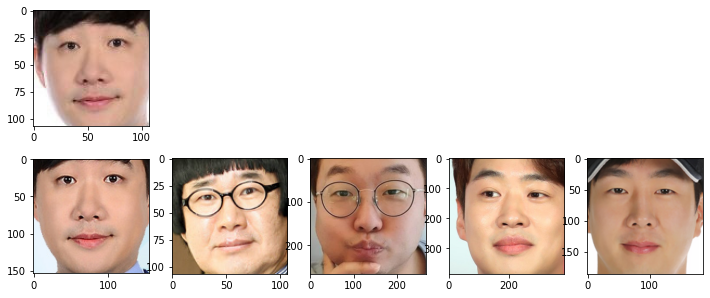

In [46]:
find_celebrity_resemblance("bae")

In [ ]:
배성재 아나운서의 다른 사진을 넣었을 때 배성재 아나운서가 가장 닮은 사람으로 나왔으므로 잘 구현되었다고 볼 수 있다. 


순위 1 : 이름(정수빈), 거리(0.36948024931155066)
순위 2 : 이름(박건우), 거리(0.39463598075368556)
순위 3 : 이름(bae), 거리(0.4084798920605736)
순위 4 : 이름(박재범), 거리(0.4107289712685671)
순위 5 : 이름(손흥민), 거리(0.4108070286335577)


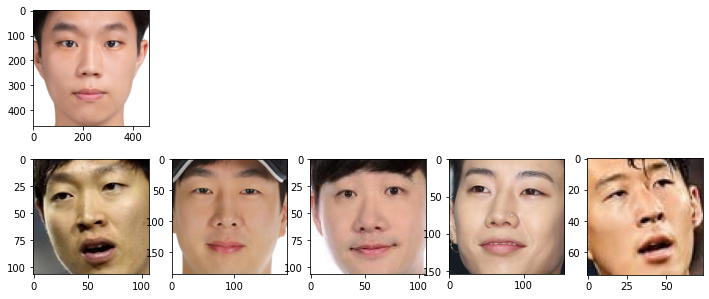

In [47]:
find_celebrity_resemblance("증명사진")

In [ ]:
다들 무쌍인 사람들이 나온 것 같다. 생각보다 잘되는 것 같아 신기하다. 


#회고 
생각해보면 def find_celebrity_resemblance가 사진을 입력받아서 해당 사진과 기존의 디렉토리를 비교해서 리스트를 반환해야될 것 같은데, 
기존의 함수를 그대로 갖다쓰다보니 비교해야될 사진까지 다 디렉토리에 넣고 이름을 기준으로 찾게 되었다. 다음엔 tkniter까지 사용해서 좀 더 잘해보고 싶다.  